# Full Perturbed Model

In [48]:
### Set directory

import os
os.chdir('/groups/turaga/home/kuperwajsi/bay_inf')

In [49]:
### Restore trained model and parameters

import tensorflow as tf
from model import *
saver.restore(sess, "./photo_full/model_photo_full")

INFO:tensorflow:Restoring parameters from ./photo_full/model_photo_full


In [36]:
import h5py
import numpy as np

### Load clean data
clean_data = 'l161_clean.h5'
file = h5py.File(clean_data, 'r')

### Extract perturbations and fluorescent traces
traces_spont = file["spont/traces"].value/100
traces_photo = file["photo/traces"].value/100
traces_spont = (traces_spont - np.mean(traces_spont) + np.mean(traces_photo))*\
                   np.sqrt(np.var(traces_photo)/np.var(traces_spont))

### Specify for perturbed data
stim_frames = file["%(data)s/frames" % dm].value
stim_cells  = file["%(data)s/types" % dm].value - 1

T_total = traces.shape[0]
Ns = np.max(stim_cells) + 1
stim = np.zeros([T_total, Ns])
stim_frames = np.ones([5, 1], dtype=np.int32) * np.transpose(stim_frames)
stim[(stim_frames, stim_cells)] = 1

### Set correct dimensions for fluorescence and perturbations 
traces_photo_cut = traces_photo[4000:5000, :]
perturbations_photo_cut = stim[4000:5000, :]

file.close()

In [37]:
### Recover the inferred spikes
inferred_spikes = sess.run(spikes.Q.mean(), feed_dict = {ca_raw: traces_photo_cut, raw_inp: perturbations_photo_cut})

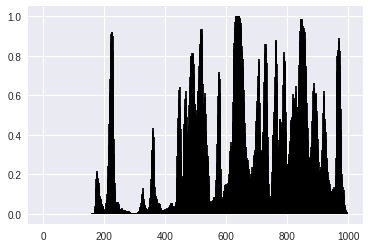

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

### Quick plot inferred spikes
plt.vlines(np.arange(inferred_spikes.shape[0]), np.zeros(inferred_spikes.shape[0]), inferred_spikes[:, 0])

In [39]:
### Function to plot inferred spikes with fluorescence traces
def plot_inf_soma_real(datatype, infered_spike, test_fluor,
                       bin_period, cp, fs=14, upsample=1):
    infered_spike = infered_spike.reshape((test_fluor.shape[0], upsample))
    infered = np.sum(infered_spike, axis=1)
    fig = plt.figure(figsize=(12, 4))
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])

    x = np.arange(len(test_fluor))
    t = x * bin_period
    # gs.tight_layout(fig, h_pad=-1.5)


    ax1.set_ylabel(datatype, fontsize=fs + 2, y=0.5)
    ax1.plot(t, test_fluor, label="Trace", color=cp[4])
    ax1.get_xaxis().set_ticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([t.min(), t.max()])

    ax3.vlines(t, np.zeros_like(infered), infered, color=cp[1])
    ax3.set_xlim([t.min(), t.max()])
    ax3.set_ylim([0, upsample])
    ax3.set_ylabel('Spike Rate', fontsize=fs + 2, y=0.5)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)
    ax3.set_xlabel('Time in Seconds', fontsize=fs + 2)

    # ax1.tick_params(axis='both', labelsize=fs)
    # ax3.tick_params(axis='both', labelsize=fs)

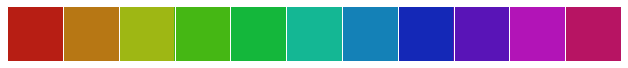

In [40]:
### Set color palette
import seaborn as sns
cp = sns.hls_palette(11, l=.4, s=.8)
sns.palplot(cp)
import matplotlib.gridspec as gridspec

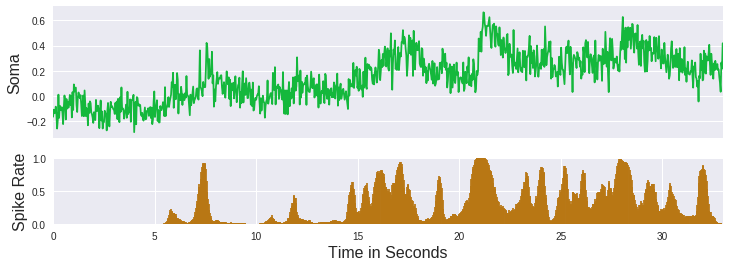

In [47]:
plot_inf_soma_real('Soma', inferred_spikes[:, 0], traces_photo_cut[:, 0], .033, cp)

In [42]:
### Recover the reconstructed fluorescent traces
reconstruction = sess.run(calcium.Erecon, feed_dict = {ca_raw: traces_photo_cut, raw_inp: perturbations_photo_cut})

In [43]:
### Function to plot reconstructions together with the real traces
def plot_inf_soma_gt_recon(datatype, infered_spike, gt_spike, test_fluor,
                           recon_fluor, bin_period, cp, fs=14, upsample=1,
                           start_sample=0, fig=None, grid=None):
    infered_spike = infered_spike.reshape((test_fluor.shape[0], upsample))
    infered = np.sum(infered_spike, axis=1)
    if fig is None:
        fig = plt.figure(figsize=(12, 6))
        gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
    else:
        gs = gridspec.GridSpecFromSubplotSpec(3, 1,
                                              subplot_spec=grid, height_ratios=[2, 1, 1])

    ax1 = fig.add_subplot(gs[0])
    ax3 = fig.add_subplot(gs[1])
    ax4 = fig.add_subplot(gs[2])

    x = np.arange(len(test_fluor)) + start_sample
    t = x * bin_period
    # gs.tight_layout(fig, h_pad=-1.5)

    ax1.set_ylabel(datatype, fontsize=fs + 2, y=0.5)
    ax1.plot(t, test_fluor, label="Trace", color=cp[4])
    ax1.plot(t, recon_fluor, label="Recon", color=cp[1])
    ax1.get_xaxis().set_ticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.set_xlim([t.min(), t.max()])

    ax3.vlines(t, np.zeros_like(infered), infered, color=cp[1])
    ax3.set_xlim([t.min(), t.max()])
    ax3.set_ylim([0, upsample])
    ax3.set_ylabel('inferred', fontsize=fs + 2, y=0.5)
    ax3.spines['top'].set_visible(False)
    ax3.spines['right'].set_visible(False)

    ax4.vlines(t, np.zeros_like(gt_spike), gt_spike, color=cp[0])
    ax4.set_xlim([t.min(), t.max()])
    ax4.set_ylim([0, upsample])
    ax4.set_ylabel('gt', fontsize=fs + 2, y=0.5)
    ax4.spines['top'].set_visible(False)
    ax4.spines['right'].set_visible(False)
    ax4.set_xlabel('Time in Seconds', fontsize=fs + 2)

    # ax1.tick_params(axis='both', labelsize=fs)
    # ax3.tick_params(axis='both', labelsize=fs)

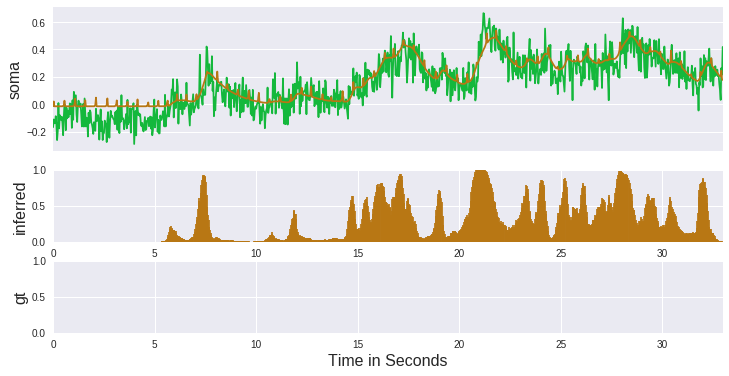

In [46]:
plot_inf_soma_gt_recon('soma', inferred_spikes[:, 0], 0, traces_photo_cut[:, 0], reconstruction[:, 0], .033, cp)